In [1]:
# 数据处理
import pandas as pd
import numpy as np

# 模型和评估
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# 数据分割和交叉验证
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

# 特征预处理
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv('parkinsons_updrs.data')

# 定义目标变量和特征
random_state = 42
y = df['total_UPDRS']
X = df.loc[:, ~df.columns.isin(['total_UPDRS', 'test_time', 'Jitter(%)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer','Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA'])]
groups = df['subject#']


# Split into test and other sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.8, random_state=random_state)
test_idx, other_idx = next(gss.split(X, y, groups))

X_test, y_test, groups_test = X.iloc[test_idx], y.iloc[test_idx], groups.iloc[test_idx]
X_other, y_other, groups_other = X.iloc[other_idx], y.iloc[other_idx], groups.iloc[other_idx]

# 定义参数和结果存储
param_grid = {
    'n_neighbors': [90, 100, 200, 300, 400],
    'weights': ['uniform', 'distance']
}

# 用于存储结果
test_scores = []
best_models = []

group_kfold = GroupKFold(n_splits=4)

for train_idx, val_idx in group_kfold.split(X_other, y_other, groups_other):
    # Train and validation split
    X_train, X_val = X_other.iloc[train_idx], X_other.iloc[val_idx]
    y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]

    # Preprocessing pipeline
    onehot_ftrs = ['sex']
    std_ftrs = ['age', 'motor_UPDRS', 'Jitter(Abs)', 'Shimmer(dB)', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
            ('std', StandardScaler(), std_ftrs)
        ]
    )

    clf = Pipeline(steps=[('preprocessor', preprocessor)])

    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)

    # 手动调参
    best_params = None
    best_val_rmse = float('inf')
    best_model = None


    for n_neighbors in param_grid['n_neighbors']:
        for weights in param_grid['weights']:
            # Initialize XGBRegressor
            model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
                
            # Fit on training data
            model.fit(X_train_prep, y_train)
                
            # Evaluate on validation set
            y_val_pred = model.predict(X_val_prep)
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

            y_train_pred = model.predict(X_train_prep)

            print(f"  Params: n_neighbors={n_neighbors}, weights={weights}, Validation RMSE: {val_rmse:.4f}")
                
            # Save the best model
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_params = (n_neighbors, weights)
                best_model = model

    # 测试集上评估最佳模型
    y_test_pred = best_model.predict(X_test_prep)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_scores.append(test_rmse)
    best_models.append(best_model)

    print(f"Best Params: {best_params}, Test RMSE: {test_rmse:.4f}")
print(np.std(test_rmse))

    # 输出表现最佳的模型
best_model_index = np.argmin(test_scores)
global_best_model = best_models[best_model_index]
print("\nBest Model Across All Random States:")
print(global_best_model)

  Params: n_neighbors=90, weights=uniform, Validation RMSE: 7.2805
  Params: n_neighbors=90, weights=distance, Validation RMSE: 7.2410
  Params: n_neighbors=100, weights=uniform, Validation RMSE: 7.3256
  Params: n_neighbors=100, weights=distance, Validation RMSE: 7.2823
  Params: n_neighbors=200, weights=uniform, Validation RMSE: 7.6970
  Params: n_neighbors=200, weights=distance, Validation RMSE: 7.6268
  Params: n_neighbors=300, weights=uniform, Validation RMSE: 7.9982
  Params: n_neighbors=300, weights=distance, Validation RMSE: 7.9077
  Params: n_neighbors=400, weights=uniform, Validation RMSE: 8.2605
  Params: n_neighbors=400, weights=distance, Validation RMSE: 8.1502
  Params: n_neighbors=700, weights=uniform, Validation RMSE: 8.9136
  Params: n_neighbors=700, weights=distance, Validation RMSE: 8.7493
  Params: n_neighbors=1000, weights=uniform, Validation RMSE: 9.4710
  Params: n_neighbors=1000, weights=distance, Validation RMSE: 9.2529
Best Params: (90, 'distance'), Test RMSE:

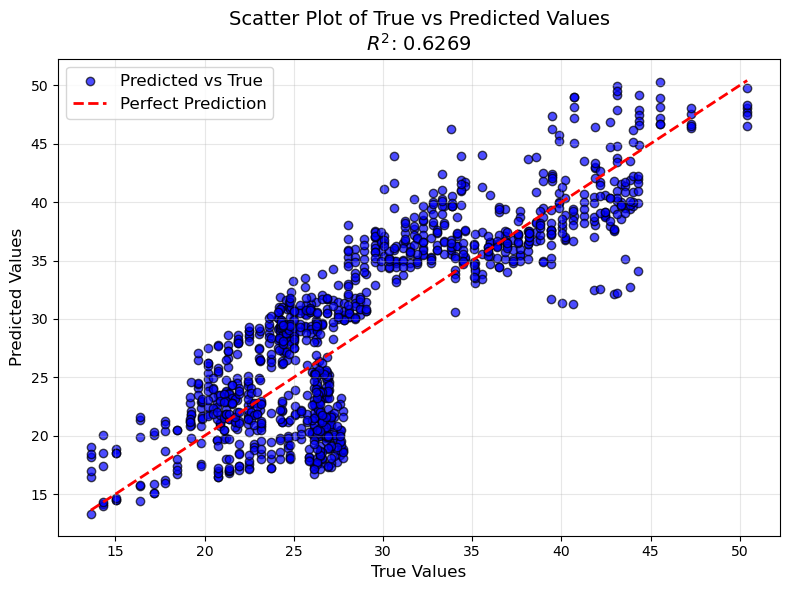

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R^2 score
r2 = r2_score(y_test, y_test_pred)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', edgecolor='k', label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title(f"Scatter Plot of True vs Predicted Values\n$R^2$: {r2:.4f}", fontsize=14)
plt.xlabel("True Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()